In [99]:
import qpms
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate
ň = np.newaxis

In [100]:
TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/cylinder_50nm_lMax2_long.TMatrix'
Wfile = '/l/dispdatar/fulls'
#Wfile = '/u/46/necadam1/unix/qpms/qpms/apps/test/3out'
#Wfile_long = '/u/46/necadam1/unix/qpms/qpms/apps/test/3long'
#Wfile_short = '/u/46/necadam1/unix/qpms/qpms/apps/test/3short'


In [101]:
wdata = qpms.loadWfile(Wfile)
#wdata = qpms.loadWfile(Wfile_long)
#wdata_short = qpms.loadWfile(Wfile_short)
#wdata_long = qpms.loadWfile(Wfile_long)
TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new')

In [102]:
lMax = lMaxTM 
npart = 2
nelem = qpms.get_nelem(lMax)
nomega = 400 # 286
nk = 150 #100

In [103]:
#symmetrize TMatrices
yfl = qpms.yflip_tyty(lMax)
xfl = qpms.xflip_tyty(lMax)
zfl = qpms.zflip_tyty(lMax)
TMatrix=TMatrices_orig
TMatrix_sym = (TMatrix + qpms.apply_ndmatrix_left(yfl,qpms.apply_ndmatrix_left(yfl, TMatrix, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(xfl,qpms.apply_ndmatrix_left(xfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(zfl,qpms.apply_ndmatrix_left(zfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
rotN = 600

TMatrix_contribs = np.empty((rotN,)+TMatrix.shape, dtype=np.complex_)
for i in range(rotN):
    rotangle = 2*np.pi*i / rotN
    rot =  qpms.WignerD_yy_fromvector(lMax,np.array([0,0,rotangle]))
    rotinv = qpms.WignerD_yy_fromvector(lMax,np.array([0,0,-rotangle]))
    TMatrix_contribs[i] = qpms.apply_matrix_left(rot,qpms.apply_matrix_left(rotinv, TMatrix_sym, -3),-1)
TMatrix_sym = np.sum(TMatrix_contribs, axis=0) / rotN
TMatrix_sym[np.abs(TMatrix_sym) <= 1e-16] = 0

In [104]:

TMatrices_interp(freqs_orig[2]).shape

(2, 8, 2, 8)

In [106]:
# TODO process (interpolate and symmetrize) T-matrix here
TMatrices_interp = interpolate.interp1d(freqs_orig, TMatrix_sym, axis = 0, kind='linear', fill_value='extrapolate')


In [107]:
Wmatrices = wdata['Ws'].reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
#TMatrices = TMatrix_sym.reshape((nomega,1,2,nelem,2,nelem))
ks = wdata['ks'].reshape((nomega,nk,2))
freqs = wdata['freqs'].reshape((nomega,nk))
Wmatrices.shape, TMatrices.shape, ks.shape

((165, 201, 2, 2, 8, 2, 2, 8), (286, 1, 2, 8, 2, 8), (165, 201, 2))

In [108]:
TMatrices_orig.shape, ks.shape, freqs.shape

((286, 2, 8, 2, 8), (165, 201, 2), (165, 201))

In [109]:
freqs_weirdunits_orig[-1]

7.365

In [110]:
allU = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allV = np.full((nomega,nk,npart*2*nelem,npart*2*nelem), np.nan, dtype=complex)
allS = np.full((nomega,nk,npart*2*nelem), np.nan)

In [111]:
for omi in range(nomega):
    for ki in range(nk):
        W = Wmatrices[omi,ki]
        T = TMatrices_interp(freqs[omi,ki])
        TW = np.sum(
            T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
        , axis = (-5,-4))
        iden = np.eye(npart*2*nelem)
        iden.shape = (npart,2,nelem,npart,2,nelem)
        finalMatrix = iden-TW
        try:
            allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*2*nelem,npart*2*nelem)))
        except ValueError:
            pass
                

In [112]:
allS[2,59]

array([1.00754414, 1.00718578, 1.00433923, 1.00423296, 1.00364088,
       1.00335329, 1.00124123, 1.00083547, 1.00082851, 1.00033553,
       1.00029528, 1.00020825, 1.00000169, 0.99999742, 0.99999667,
       0.99999573, 0.99999253, 0.99998695, 0.99997329, 0.99988746,
       0.99988008, 0.99987387, 0.99979039, 0.99978282, 0.99956147,
       0.9995343 , 0.99651496, 0.99361912, 0.99338804, 0.99263544,
       0.99165828, 0.98195069])

In [113]:
wdata['freqs_weirdunits'].reshape((nomega, nk))[110,85]
ks[110,85]

array([      0.        , 4161442.78606965])

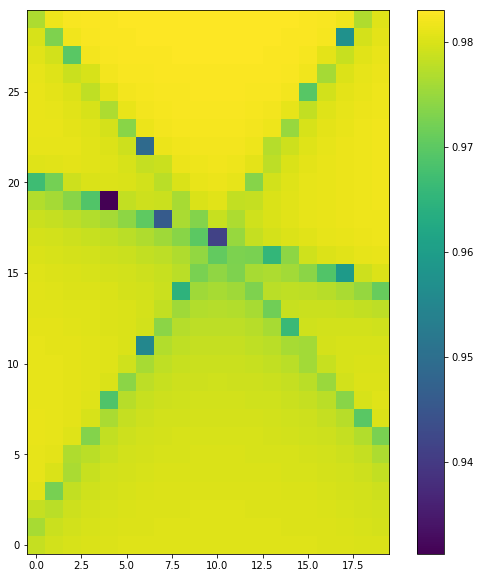

In [87]:
#full
plt.figure(figsize=(10,10))
plt.imshow(allS[85:115,90:110,-1], origin = 'lower')
plt.colorbar()

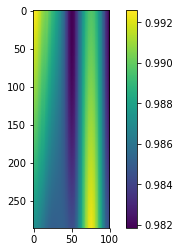

In [42]:
#short
plt.imshow(allS[:,:,-1])
plt.colorbar()

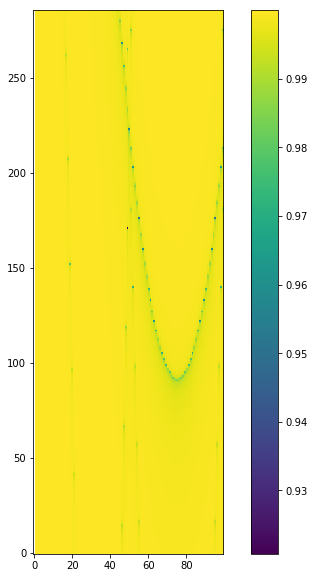

In [25]:
%matplotlib inline
#long
plt.figure(figsize=(10,10))
plt.imshow(allS[:,:,-1], origin = 'lower')
plt.colorbar()

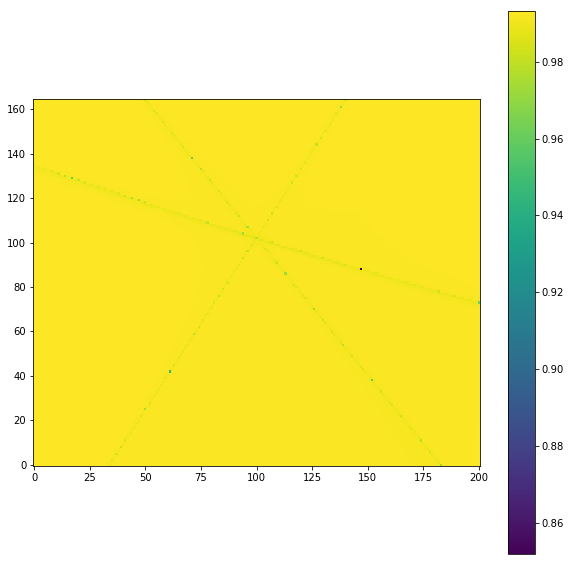

In [115]:
%matplotlib inline
#full reverse
plt.figure(figsize=(10,10))
plt.imshow(allS[:,:,-3], origin = 'lower')
plt.colorbar()

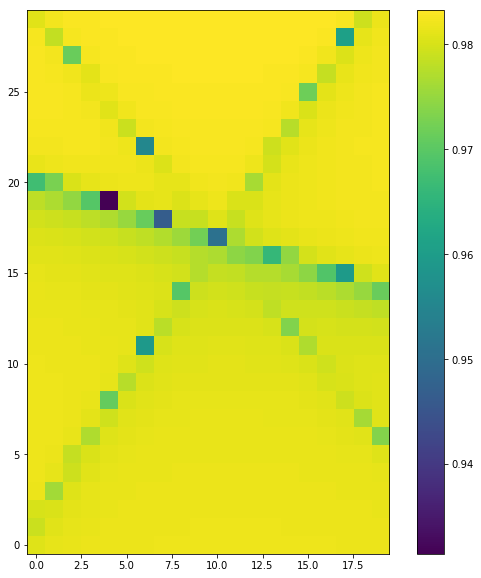

In [124]:
plt.figure(figsize=(10,10))
plt.imshow(allS[85:115,90:110,-1], origin = 'lower')
plt.colorbar()